# Machine Learning Foundation

## Course 6, Part h: Survival Modeling DEMO

## Learning Outcomes

You should walk away from this demonstration with:

1. An understanding of how to approach Survival Analysis.
2. Knowing how to prepare Kaplan-Meier curves for various subgroups.
3. Run a basic Cox survival regression 

__Installation notes:__
This demo uses Python's [lifelines](https://lifelines.readthedocs.io/en/latest/) package. It can be installed using the following command:

```conda install -c conda-forge lifelines```



In [3]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
import warnings
import os
import sys

sys.path.append(r"IBM_Specialized_Models/Time Series and Survival Analysis")
os.chdir(
    r"C:/Users/cjr21/OneDrive/Documents/IBM_Specialized_Models/Time Series and Survival Analysis"
)
from colorsetup import colors, palette

os.chdir(
    r"C:/Users/cjr21/OneDrive/Documents/IBM_Specialized_Models/Time Series and Survival Analysis/data"
)
sns.set_palette(palette)

---

# Section 1: Import and Explore Relevant Data

We will use the Churn Dataset described in the lecture for this demonstration. Let's start by reading in the data:

In [4]:
df = pd.read_pickle("churndata.pkl")
df

,id,months,offer,phone,multiple,internet_type,gb_mon,security,backup,protection,...,unlimited,contract,paperless,payment,monthly,total_revenue,satisfaction,churn_value,churn_score,cltv
0,8779-QRDMV,1,None,No,No,DSL,8,No,No,Yes,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,59.65,3,1,91,5433
1,7495-OOKFY,8,Offer E,Yes,Yes,Fiber Optic,17,No,Yes,No,...,Yes,Month-to-Month,Yes,Credit Card,80.65,1024.10,3,1,69,5302
2,1658-BYGOY,18,Offer D,Yes,Yes,Fiber Optic,52,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1910.88,2,1,81,3179
3,4598-XLKNJ,25,Offer C,Yes,No,Fiber Optic,12,No,Yes,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2995.07,2,1,88,5337
4,4846-WHAFZ,37,Offer C,Yes,Yes,Fiber Optic,14,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,3102.36,2,1,67,2793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,72,None,Yes,No,None,0,No,No,No,...,No,Two Year,Yes,Bank Withdrawal,21.15,3039.53,5,0,45,5306
7039,6840-RESVB,24,Offer C,Yes,Yes,Cable,24,Yes,No,Yes,...,Yes,One Year,Yes,Mailed Check,84.80,2807.47,3,0,59,2140
7040,2234-XADUH,72,None,Yes,Yes,Fiber Optic,59,No,Yes,Yes,...,Yes,One Year,Yes,Credit Card,103.20,9453.04,4,0,71,5560
7041,4801-JZAZL,11,None,No,No,DSL,17,Yes,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,319.21,4,0,59,2793


Here, we can see various categories of customer variables, as well as `churn_value` (an indicator for whether the customer has left the sample), and `months` (the time variable). Let's start with some simple EDA related to these variables:

<Axes: xlabel='churn_value', ylabel='months'>

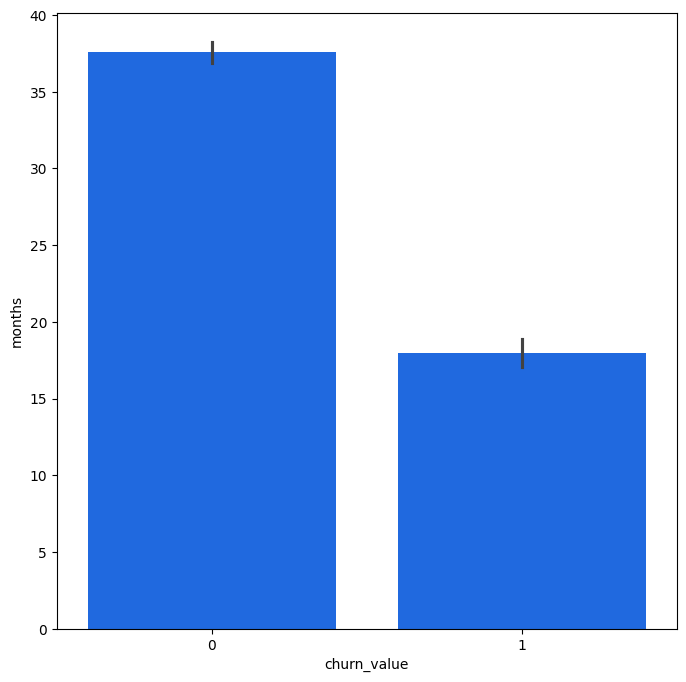

In [5]:
plt.figure(figsize=(8, 8))
sns.barplot(data=df, x="churn_value", y="months")

Clearly the average tenure is shorter for those that have churned. As we are interested in understanding the time dimension (how long someone will remain a customer), it is important to understand that our data are censored, i.e. the number of months before churn is biased downwards for customers who have not yet churned.

# Section 2: Plotting the Kaplan-Meier Curve

The Kaplan-Meier Curve represents a simple non-parametric visualization of survival likelihood function in our data. In that sense, it can be thought of as part of the EDA process for survival analysis. Let's start by fitting a simple Kaplan-Meier Curve on our data.

Text(0, 0.5, 'Survival probability')

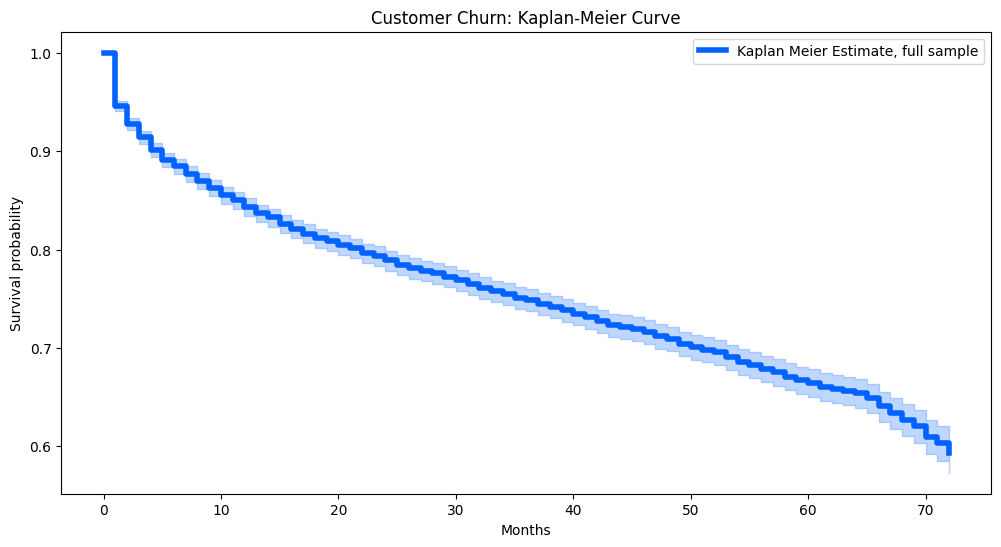

In [6]:
kmf = KaplanMeierFitter()

kmf.fit(df.months, df.churn_value, label="Kaplan Meier Estimate, full sample")

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title("Customer Churn: Kaplan-Meier Curve")
plt.xlabel("Months")
plt.ylabel("Survival probability")

# Section 3: Examining Variables

As we continue to examine the survival function, we may want to relate survival risk with features, or characteristics of our customers. In this example, we will look at diffences in survival risk for customers who have only a single service, vs. customers with multiple services. We can start by plotting a simple histogram for each category, looking at differences between churned and not-churned subsamples.

churn_value
0    Axes(0.547727,0.11;0.352273x0.77)
1    Axes(0.547727,0.11;0.352273x0.77)
Name: months, dtype: object

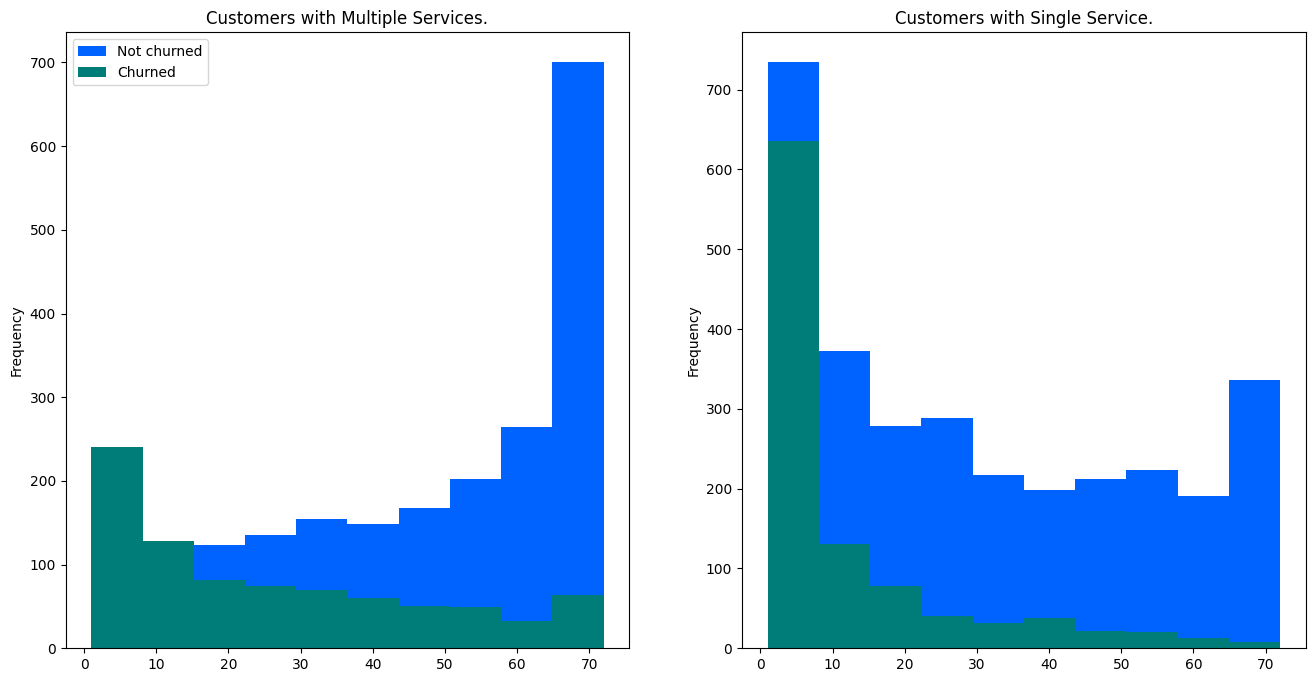

In [7]:
# Let's look at the 'multiple services variable'
df1 = df[df.multiple == "Yes"]
df2 = df[df.multiple == "No"]
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
df1.groupby("churn_value")["months"].plot(
    kind="hist", ax=ax[0], title="Customers with Multiple Services."
)
ax[0].legend(labels=["Not churned", "Churned"])
df2.groupby("churn_value")["months"].plot(
    kind="hist", ax=ax[1], title="Customers with Single Service."
)

We can see differences across these groups, let's examing Kaplan-Meier curves for various subsamples. This involves fitting the Kaplan Meier estimator separately for each subsample. 

Text(0, 0.5, 'Survival probability')

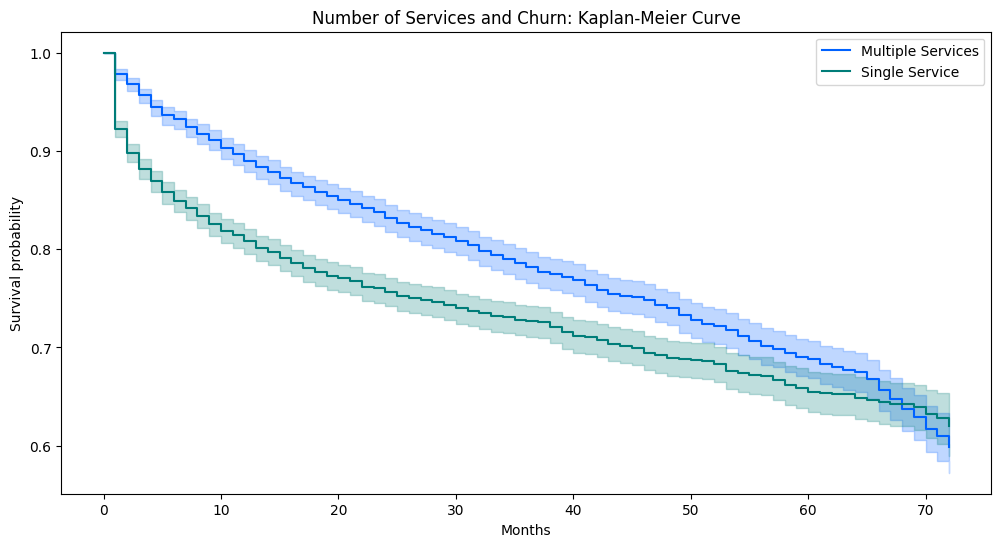

In [8]:
kmf.fit(df1.months, df1.churn_value)
kmf.plot(label="Multiple Services", figsize=(12, 6))
kmf.fit(df2.months, df2.churn_value)
kmf.plot(label="Single Service")
plt.title("Number of Services and Churn: Kaplan-Meier Curve")
plt.xlabel("Months")
plt.ylabel("Survival probability")

# Section 4: Cox Proportional Hazards Model

Having looked at our data and related Kaplan-Meier curves, we can formalize the analysis by running survival regression. There are several available models here, documented in the Python [lifelines](https://lifelines.readthedocs.io/en/latest/) module. As we discussed in the course, the Cox model estimates a baseline hazard rate, and assumes features impact this hazard rate proportionally. While this is a strong assumption (and may not be true in general), the model still provides insight into the role of features and their importance impacting survival risk. Let's begin by setting data up for the Cox survival regression.

In [9]:
# Setting up the data
dfu = df[["multiple", "churn_value"]]
dfd = pd.get_dummies(dfu, drop_first=True)
dfd["months"] = df.months
dfd.rename(columns={"multiple_Yes": "Multiple Services"}, inplace=True)

Now, let's fit a Cox proportional hazard model using the Multiple Services variable.

In [10]:
cph = CoxPHFitter()
cph.fit(dfd, duration_col="months", event_col="churn_value")
cph.print_summary(style="ascii")

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'months'
                event col = 'churn_value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15641.90
         time fit was run = 2024-09-13 02:01:12 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Multiple Services -0.24      0.79      0.05           -0.33           -0.15                0.72                0.86

                   cmp to     z      p  -log2(p)
covariate                                       
Multiple Services    0.00 -5.06 <0.005     21.18
---
Concordance = 0.55
Partial AIC = 31285.81
log-likelihood ratio test = 25.72 on 1 df
-log2(p) of ll-ratio test = 21.27



Here, we see regression output for the estimated cox model. The Cox model objet also allows us to plot coefficient estimates to assess their significance, using the `plot` method.

<Axes: xlabel='log(HR) (95% CI)'>

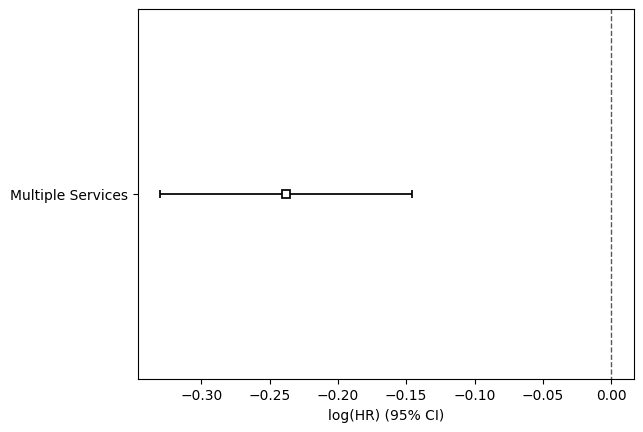

In [11]:
cph.plot()

Here, we see the coefficient estimate, along with error bars used to assess statistical significance. The result is significantly different from zero, indicating a negative effect of the Multiple Services variable in our analysis.

The Cox model object also allows us to assess results visually, by plotting resulting estimates of survival risk by covariate groups, using the `plot_covariate_groups` method. This can be useful to see estimated changes in survival risk across groups.

<Axes: >

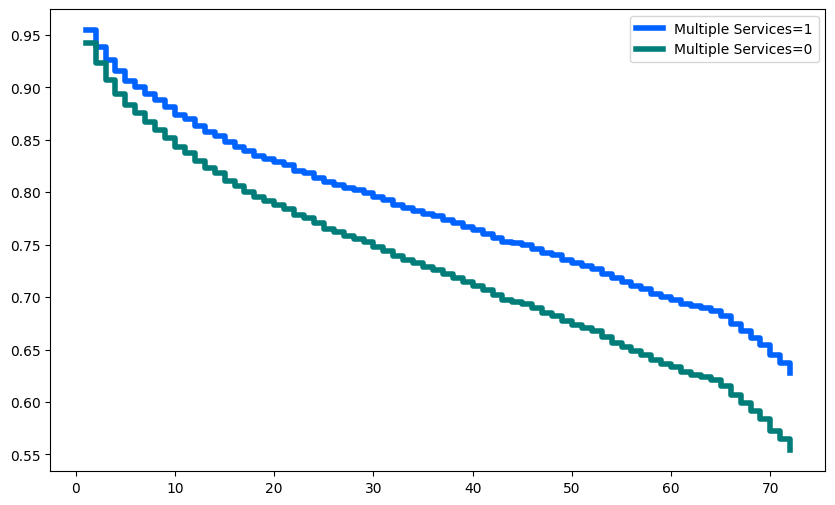

In [12]:
cph.plot_covariate_groups(
    "Multiple Services", [1, 0], plot_baseline=False, figsize=(10, 6), lw=4
)

To compare the impact across variables, let's include a few more variables: Satisfaction, Security Service, Backup Service, and Support, and re-run our analysis. We begin by setting up the data, as before.

In [13]:
# Including additional variables, data setup
dfu = df[["churn_value", "satisfaction", "security", "backup", "support"]]
dfd = pd.get_dummies(dfu, drop_first=True)
dfd["months"] = df.months
# dfd.rename(columns={'multiple_Yes':'Multiple Services'}, inplace=True)
dfd.rename(columns={"backup_Yes": "Backup Service"}, inplace=True)
dfd.rename(columns={"security_Yes": "Security Service"}, inplace=True)
dfd.rename(columns={"support_Yes": "Support Service"}, inplace=True)

In [14]:
# Fitting Cox Proportional Model
cph = CoxPHFitter()
cph.fit(dfd, duration_col="months", event_col="churn_value")
cph.print_summary(style="ascii")

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'months'
                event col = 'churn_value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13308.14
         time fit was run = 2024-09-13 02:02:21 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
satisfaction     -1.30      0.27      0.02           -1.34           -1.25                0.26                0.29
Security Service -1.09      0.34      0.07           -1.22           -0.96                0.29                0.38
Backup Service   -0.63      0.53      0.05           -0.73           -0.52                0.48                0.59
Support Service  -0.49      0.61      0.06           -

Again, we see results of regression output, denoting significance levels for each variable, as well as information about our dataset and model fit. 
As above, let's plot coefficients for different variables. This allows us to compare magnitudes and assess which variables have a larger influence on survival risk. 

<Axes: xlabel='log(HR) (95% CI)'>

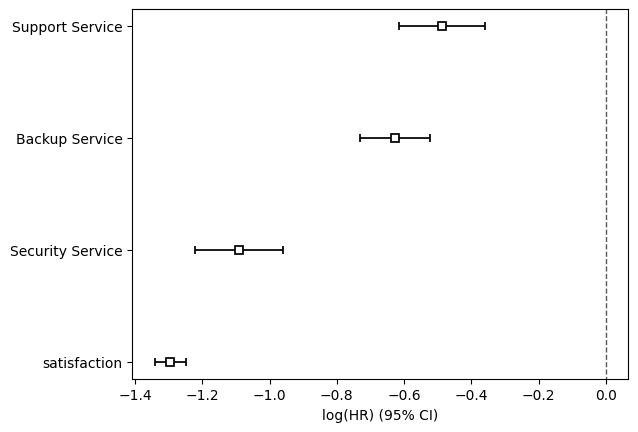

In [15]:
cph.plot()

Here, we see coefficient estimates for several variables, which helps us understand both their significance, as well as their relative magnitudes. The Satisfaction variable seems to have the largest impact on survival risk.

Let's look at results for the Satisfaction variable by covariate group. This allows us to plot estimated survival rates for different values of the Satisfaction and Security variables.

<Axes: >

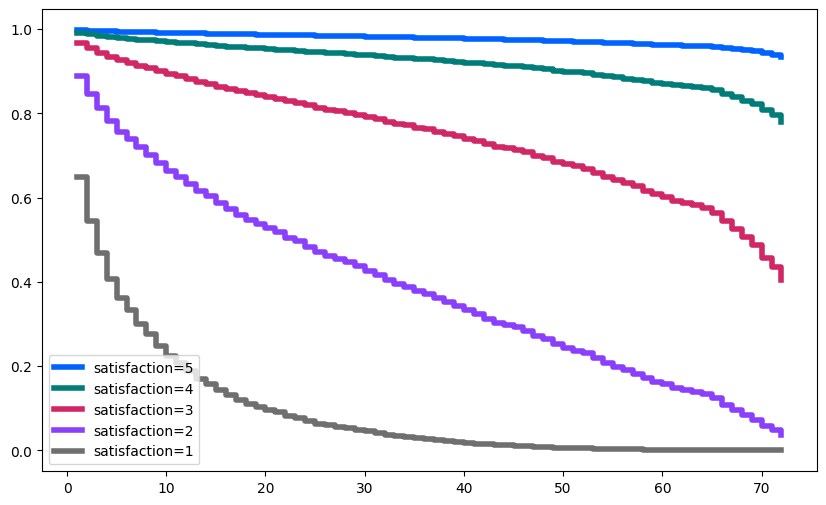

In [16]:
cph.plot_covariate_groups(
    "satisfaction", [5, 4, 3, 2, 1], plot_baseline=False, figsize=(10, 6), lw=4
)

Our estimated survival functions differ substantially based on this variable (we knew from the previous chart that this was likely the case).

# Summary
In this notebook, we have covered: 

1. How to approach Survival Analysis.
2. Preparing Kaplan-Meier curves for various subgroups.
3. Runing a basic Cox survival regression. 

---
### Machine Learning Foundation (C) 2020 IBM Corporation